## Importing modules:

In [1]:
import sys
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import seaborn as sea
import geodatasets as gds
import fiona #geopandas needs this for shapefiles
from geopy.distance import geodesic
from matplotlib import colormaps
from shapely.geometry import Point

pd.set_option('display.max_columns', 70) # Set max display to 70 columns
pd.set_option('display.float_format', '{:.0f}'.format) #Causes pandas to NOT output integers as exponents

/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Turning data, as well as geospatial data (census tract, municipality, and law enforcement boundaries), into dataframes of only Utah data that join on tract, county or municipality FIPS (takes over 10 mins):

In [2]:
ahrq_df = pd.read_excel(r"Data Files/sdoh_2020_tract_1_0.xlsx", sheet_name='Data')
ahrq_df = ahrq_df[ahrq_df["STATEFIPS"] == 49]
ahrq_df = gpd.GeoDataFrame(ahrq_df) #AHRQ SDOH variables for Gini Index, Poverty, Median houshold income, Unemployment, Uninsured, Citizenship, Foreign-born, UT population above 1-year-old

air_quality_df = pd.read_csv(r"Data Files/annual_conc_by_monitor_2020.csv") # Air Quality

shutil.copy(r"Data Files/PLACES__Census_Tract_Data__GIS_Friendly_Format___2024_release_20250417.csv", r"Data Files/PLACES_Utah_ct_Asthma.csv")
asthma_df = pd.read_csv(r"Data Files/PLACES_Utah_ct_Asthma.csv") #create Asthma data df on CASTHMA_CrudePrev
asthma_df = gpd.GeoDataFrame(asthma_df)

crime_df = pd.read_csv(r"Data Files/crime2022.csv") #Crime on "CRIMES_PER_1K"
crime_df = gpd.GeoDataFrame(crime_df)

resp_haz_df = pd.read_excel(r"Data Files/Region8_CancerRisk_by_block_poll.xlsx") #create Respiratory Hazard data df (group by tract) on "Total Cancer Risk (per million) "
resp_haz_df = resp_haz_df[resp_haz_df["State"] == "UT"]
resp_haz_df = gpd.GeoDataFrame(resp_haz_df)

svi_df = pd.read_csv(r"Data Files/Utah 2020SVI.csv") #Social Vulnerability Index on "RPL_THEMES"
svi_df = gpd.GeoDataFrame(svi_df)

urban_rural_df = pd.read_csv(r"Data Files/2020_UA_BLOCKS.txt", delimiter="|", encoding="latin1") #create Urban-Rural data df (group by tract)
urban_rural_df = urban_rural_df[urban_rural_df["STATE"] == 49]
urban_rural_df = gpd.GeoDataFrame(urban_rural_df)

#CENSUS TRACT BASEMAP (which has GEOID20 as well as county FIPS)
utct_base = r"GeoFiles/CensusTracts2020.shp"
utct_base_df = gpd.read_file(utct_base)
utct_base_df = utct_base_df.to_crs(epsg=4326)
utct_base_df = gpd.GeoDataFrame(utct_base_df)

#MUNICIPALITY BOUNDARIES (which has municipality FIPS)
ut_municp = r"GeoFiles/Municipalities.shp"
ut_municp_df = gpd.read_file(ut_municp)
ut_municp_df = ut_municp_df.to_crs(epsg=4326)
ut_municp_df = gpd.GeoDataFrame(ut_municp_df)

#LAW ENFORCEMENT BOUNDARIES (which has just NAME)
utle_base = r"GeoFiles/LawEnforcementBoundaries.shp"
utle_base_df = gpd.read_file(utle_base)
utle_base_df = utle_base_df.to_crs(epsg=4326)
utle_base_df = gpd.GeoDataFrame(utle_base_df)

/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: GeoFiles/Municipalities.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: GeoFiles/LawEnforcementBoundaries.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


## Initial datatype conversions, objects to strings:

In [3]:
#Put em all in lists: 
all_dfs = [ahrq_df, air_quality_df, asthma_df, crime_df, resp_haz_df, svi_df, urban_rural_df, ut_municp_df, utct_base_df, utle_base_df]
all_df_names = ['ahrq_df', 'air_quality_df', 'asthma_df', 'crime_df', 'resp_haz_df', 'svi_df', 'urban_rural_df', 'ut_municp_df', 'utct_base_df', 'utle_base_df']
data_dfs = [ahrq_df, air_quality_df, asthma_df, crime_df, resp_haz_df, svi_df, urban_rural_df]
data_df_names = ['ahrq_df', 'air_quality_df', 'asthma_df', 'crime_df', 'resp_haz_df', 'svi_df', 'urban_rural_df']

In [4]:
#First GET INFO:

for df in all_dfs:
    df.info()

'''The most common reason for an 'object' dtype is that the column holds different types of data. 
Pandas is known for using 'object' as a catch-all for columns that don't fit into a specific numeric or string type. However, a quirk of Pandas is ALSO to label "string" datatypes as "objects." 
#First, We're going to check the dtypes in the object columns.'''

obj_cols = df.select_dtypes(include='object').columns
for n in obj_cols:
    if n in df.columns:
        print(f"{df[n].apply(type).value_counts()}\n")
            
#Now, click anywhere in the output cell, hit 'Ctrl-F', and search for '<class'. You can quickly see if these are all 'str', or can be changed to 'str'.

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 716 entries, 77275 to 77990
Columns: 329 entries, YEAR to CEN_AIAN_NH_IND
dtypes: float64(320), int64(6), object(3)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76396 entries, 0 to 76395
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State Code                     76396 non-null  int64  
 1   County Code                    76396 non-null  int64  
 2   Site Num                       76396 non-null  int64  
 3   Parameter Code                 76396 non-null  int64  
 4   POC                            76396 non-null  int64  
 5   Latitude                       76396 non-null  float64
 6   Longitude                      76396 non-null  float64
 7   Datum                          76396 non-null  object 
 8   Parameter Name                 76396 non-null  object 
 9   Sample Duration                7639

In [5]:
#And IF all are strings (spoiler: they are), run code to officially convert all "object" datatypes to "string" datatypes:
for df in all_dfs:
    
    obj_cols = df.select_dtypes(include='object').columns  
    for n in obj_cols:
        if n in df.columns:
            df[n] = df[n].astype("string")

## Now to: 
 - delete extraneous data from the data dfs,
 - create some new composite variables, and
 - adjust all the joining variables, making sure these are strings of 11 digits, with a label that matches the basemap(s).

## But first, a summary of variables, as well as the stuff we need to know for quick, organized mapping:
![Screenshot 2025-04-20 at 9.06.17 PM.png](<attachment:Screenshot 2025-04-20 at 9.06.17 PM.png>)
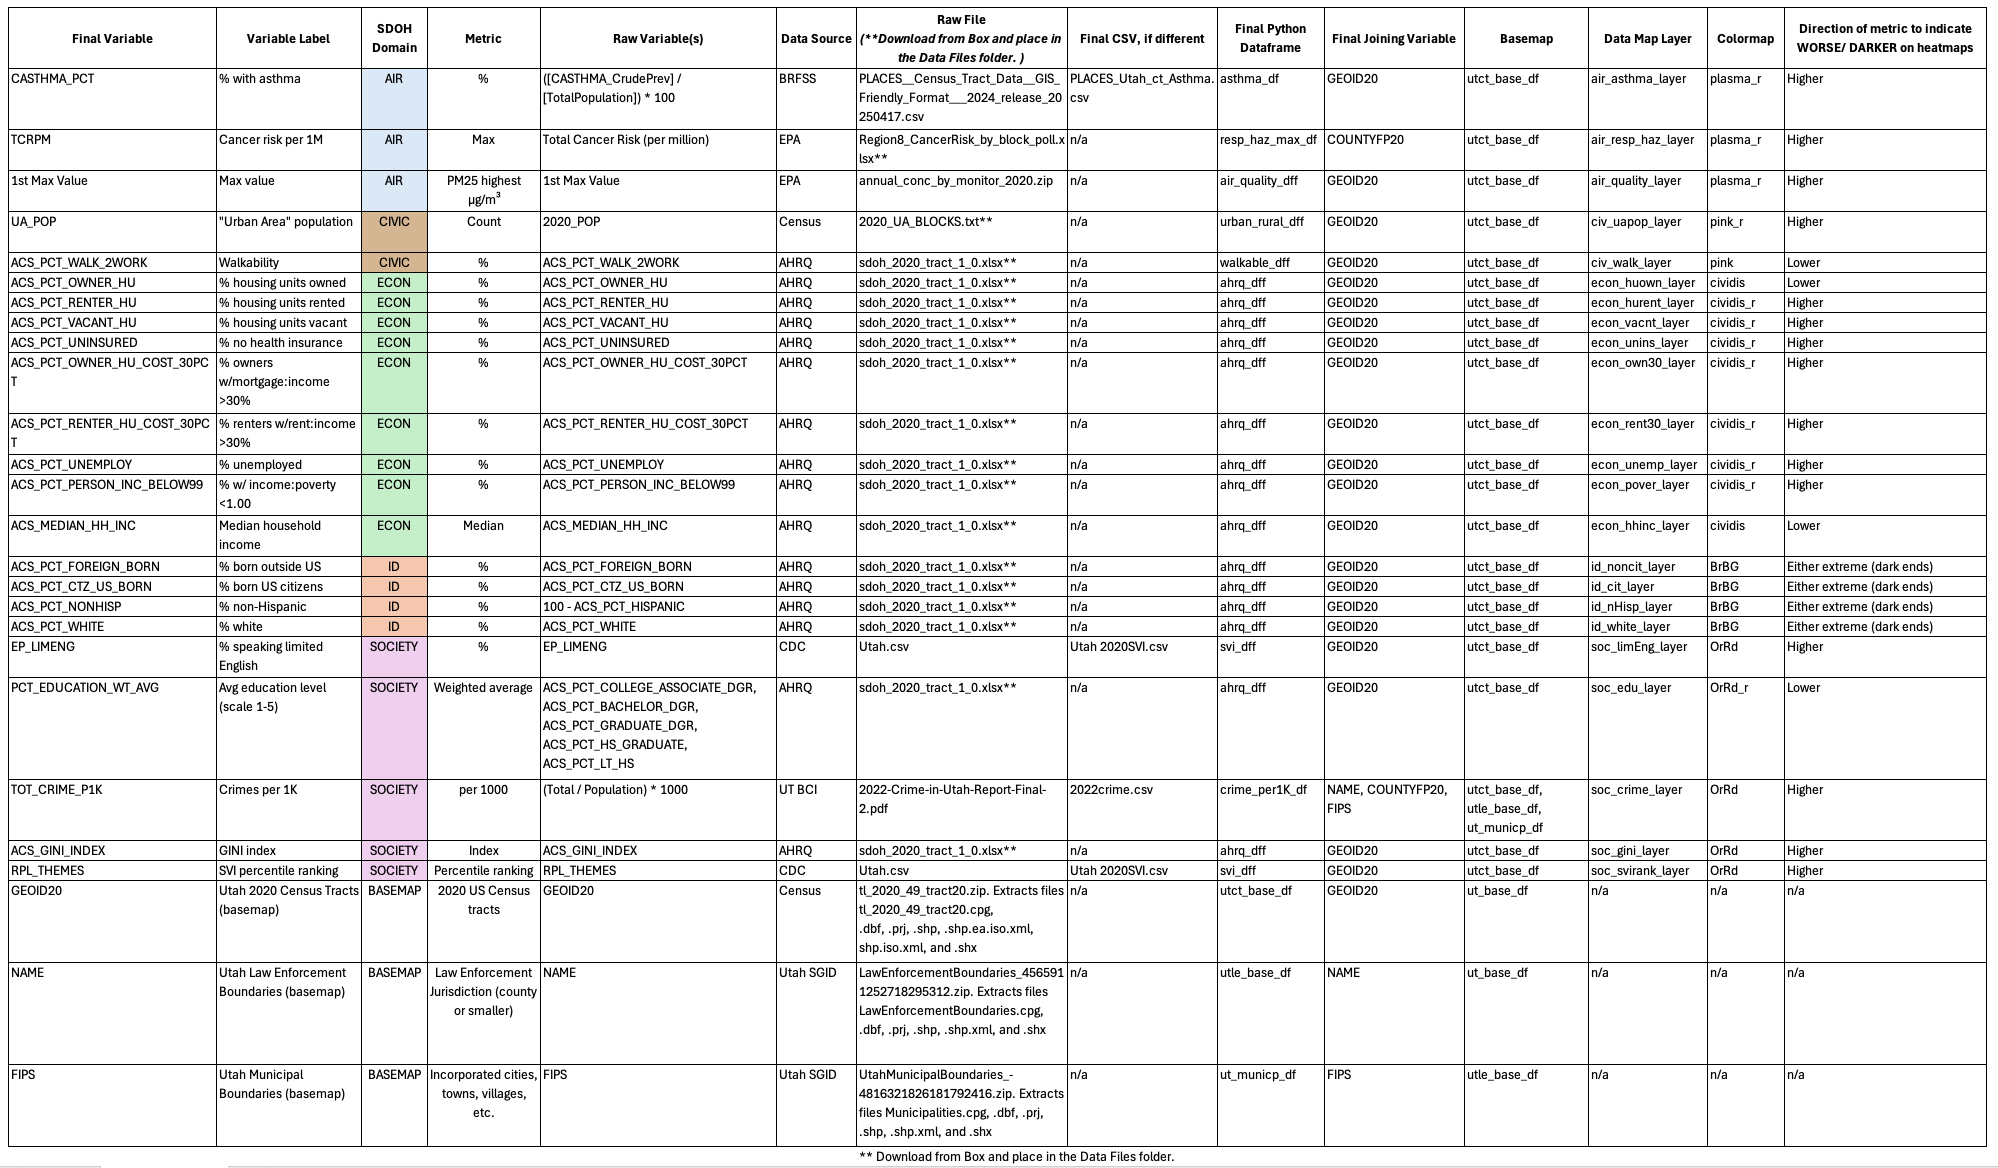

### AHRQ

In [6]:
#Slim down the df
ahrq_kept_var = ['YEAR', 'TRACTFIPS', 'COUNTYFIPS', 'STATEFIPS', 'STATE', 'COUNTY', 'REGION', 'TERRITORY', 'ACS_TOT_POP_WT', 'ACS_TOT_POP_US_ABOVE1', 'ACS_TOT_POP_ABOVE25', 'ACS_PCT_CTZ_US_BORN', 'ACS_PCT_FOREIGN_BORN', 'ACS_PCT_WHITE', 'ACS_PCT_HISPANIC', 'ACS_MEDIAN_HH_INC', 'ACS_PCT_OWNER_HU', 'ACS_PCT_OWNER_HU_COST_30PCT', 'ACS_PCT_RENTER_HU', 'ACS_PCT_RENTER_HU_COST_30PCT', 'ACS_PCT_VACANT_HU', 'ACS_PCT_UNEMPLOY', 'ACS_PCT_UNINSURED', 'ACS_PCT_PERSON_INC_BELOW99', 'ACS_PCT_WALK_2WORK', 'ACS_GINI_INDEX', 'ACS_PCT_LT_HS', 'ACS_PCT_HS_GRADUATE', 'ACS_PCT_COLLEGE_ASSOCIATE_DGR', 'ACS_PCT_BACHELOR_DGR', 'ACS_PCT_GRADUATE_DGR']
ahrq_dff = ahrq_df[ahrq_kept_var].copy()

#Create new variables from old
ahrq_dff['ACS_PCT_NONHISP'] = 100-(ahrq_dff['ACS_PCT_HISPANIC']) #Getting % Non-hispanic

ahrq_dff['PCT_EDUCATION_WT_AVG'] = (((ahrq_dff['ACS_PCT_LT_HS']*ahrq_dff['ACS_TOT_POP_ABOVE25']*1)+(ahrq_dff['ACS_PCT_HS_GRADUATE']*ahrq_dff['ACS_TOT_POP_ABOVE25']*2)+(ahrq_dff['ACS_PCT_COLLEGE_ASSOCIATE_DGR']*ahrq_dff['ACS_TOT_POP_ABOVE25']*3)+(ahrq_dff['ACS_PCT_BACHELOR_DGR']*ahrq_dff['ACS_TOT_POP_ABOVE25']*4)+(ahrq_dff['ACS_PCT_GRADUATE_DGR']*ahrq_dff['ACS_TOT_POP_ABOVE25']*5))/ahrq_dff['ACS_TOT_POP_ABOVE25'])/100
ahrq_dff['PCT_EDUCATION_WT_AVG'] = ahrq_dff['PCT_EDUCATION_WT_AVG'].round(2) #Getting a weighted average of educational attainment, less than HS through graduate degree, for people over age 25

#Fix the joining variable and put it near the other variables (it has 11 digits already; just needs to be a string and renamed)
ahrq_dff['GEOID20'] = ahrq_dff['TRACTFIPS'].astype('string')
ahrq_dff = ahrq_dff[['YEAR', 'GEOID20', 'COUNTYFIPS', 'STATEFIPS', 'STATE', 'COUNTY', 'ACS_TOT_POP_WT'] + [col for col in ahrq_dff.columns if col not in ['YEAR', 'GEOID20', 'COUNTYFIPS', 'STATEFIPS', 'STATE', 'COUNTY', 'ACS_TOT_POP_WT']]]

#ahrq_dff.head()
#ahrq_dff.info()

### Air Quality

In [7]:
# Filtering the AQ Data
air_quality_df = air_quality_df[air_quality_df['State Code'] == 49] # Utah
air_quality_df = air_quality_df[air_quality_df['Parameter Name'] == 'PM2.5 - Local Conditions'] # PM 2.5
air_quality_df = air_quality_df[air_quality_df['Pollutant Standard'].isin(['PM25 24-hour 2024', 'PM25 Annual 2024'])] # PM 2.5 standard effective 2024

In [8]:
air_quality_df.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Metric Used,Method Name,Year,Units of Measure,Event Type,Observation Count,Observation Percent,Completeness Indicator,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Primary Exceedance Count,Secondary Exceedance Count,Certification Indicator,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,1st Max DateTime,2nd Max Value,2nd Max DateTime,3rd Max Value,3rd Max DateTime,4th Max Value,4th Max DateTime,1st Max Non Overlapping Value,1st NO Max DateTime,2nd Max Non Overlapping Value,2nd NO Max DateTime,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
66556,49,5,7,88101,1,42,-112,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 24-hour 2024,Daily Mean,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2020,Micrograms/cubic meter (LC),Events Excluded,350,96,Y,353,366,0,13,2,2,Certified,0,8,6,40,2020-01-21 00:00,36,2020-01-20 00:00,32,2020-12-31 00:00,31,2020-09-07 00:00,NaN,<NA>,NaN,<NA>,31,24,20,15,10,6,2,Smithfield,675 West 220 North,Utah,Cache,Smithfield,"Logan, UT-ID",2024-08-07
66557,49,5,7,88101,1,42,-112,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 24-hour 2024,Daily Mean,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2020,Micrograms/cubic meter (LC),Events Included,353,96,Y,353,366,3,13,5,5,Certified,0,8,7,62,2020-08-21 00:00,50,2020-08-22 00:00,41,2020-08-23 00:00,40,2020-01-21 00:00,NaN,<NA>,NaN,<NA>,40,29,20,16,10,6,2,Smithfield,675 West 220 North,Utah,Cache,Smithfield,"Logan, UT-ID",2024-08-07
66558,49,5,7,88101,1,42,-112,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 24-hour 2024,Daily Mean,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2020,Micrograms/cubic meter (LC),Concurred Events Excluded,353,96,Y,353,366,3,13,5,5,Certified,0,8,7,62,2020-08-21 00:00,50,2020-08-22 00:00,41,2020-08-23 00:00,40,2020-01-21 00:00,NaN,<NA>,NaN,<NA>,40,29,20,16,10,6,2,Smithfield,675 West 220 North,Utah,Cache,Smithfield,"Logan, UT-ID",2024-08-07
66568,49,5,7,88101,1,42,-112,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 Annual 2024,Quarterly Means of Daily Means,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2020,Micrograms/cubic meter (LC),Events Included,353,96,Y,353,366,3,13,NaN,NaN,Certified,0,8,7,62,2020-08-21 00:00,50,2020-08-22 00:00,41,2020-08-23 00:00,40,2020-01-21 00:00,NaN,<NA>,NaN,<NA>,40,29,20,16,10,6,2,Smithfield,675 West 220 North,Utah,Cache,Smithfield,"Logan, UT-ID",2024-08-07
66569,49,5,7,88101,1,42,-112,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 Annual 2024,Quarterly Means of Daily Means,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2020,Micrograms/cubic meter (LC),Events Excluded,350,96,Y,353,366,0,13,NaN,NaN,Certified,0,8,6,40,2020-01-21 00:00,36,2020-01-20 00:00,32,2020-12-31 00:00,31,2020-09-07 00:00,NaN,<NA>,NaN,<NA>,31,24,20,15,10,6,2,Smithfield,675 West 220 North,Utah,Cache,Smithfield,"Logan, UT-ID",2024-08-07


In [9]:
utct_base_df.head()

,STATEFP20,COUNTYFP20,TRACTCE20,GEOID20,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,POP100,HU100,geometry
0,49,049,000901,49049000901,9.01,Census Tract,G5020,S,1686016,0,+40.3051285,-111.6922978,5559,1958,"POLYGON ((-111.70145 40.31184, -111.69974 40.3..."
1,49,049,002500,49049002500,25,Census Tract,G5020,S,1034541,0,+40.2296149,-111.6497278,4218,1653,"POLYGON ((-111.65691 40.22704, -111.6569 40.22..."
2,49,049,003401,49049003401,34.01,Census Tract,G5020,S,9085765,23788,+40.0560227,-111.7122570,3896,1233,"POLYGON ((-111.74501 40.04366, -111.74456 40.0..."
3,49,049,010210,49049010210,102.10,Census Tract,G5020,S,15810476,0,+40.4005884,-111.7306856,5868,1592,"POLYGON ((-111.7734 40.41554, -111.769 40.4155..."
4,49,049,000505,49049000505,5.05,Census Tract,G5020,S,3919712,0,+40.3700595,-111.7070846,3288,846,"POLYGON ((-111.72678 40.37546, -111.72663 40.3..."


In [10]:
print(utct_base_df.crs)
# Ensure the utct_base_df GeoDF is EPSG:4326 (WGS 84)
# This will match the format of the aq_geo_df

EPSG:4326


In [11]:
# Creating point geometries from latitude and longitude

geometry = [Point(xy) for xy in zip(air_quality_df['Longitude'], air_quality_df['Latitude'])]
aq_geo_df = gpd.GeoDataFrame(air_quality_df, geometry=geometry, crs="EPSG:4326")  # The air quality data is in WGS 84 (EPSG:4326)

In [12]:
# Spatial join between the point GeoDF and census tract DF
joined_df = gpd.sjoin(aq_geo_df, utct_base_df, predicate='within', how='left') # Using left join to keep all original data.

In [13]:
# Extract GEOID from joined GeoDF
if 'GEOID' in joined_df.columns:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'GEOID']]
elif 'GEOID20' in joined_df.columns:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'GEOID20']]
else:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude']] # if no GEOID information, keep original data.
    print("Warning: No GEOID or GEOID20 column found in census tract data.")

In [14]:
# Print head of joined_df with unique TRACTCE20 values (unique census tracts)
joined_df.loc[joined_df.drop_duplicates(subset='TRACTCE20').index].head()
joined_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 128 entries, 66556 to 68323
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   State Code                     128 non-null    int64   
 1   County Code                    128 non-null    int64   
 2   Site Num                       128 non-null    int64   
 3   Parameter Code                 128 non-null    int64   
 4   POC                            128 non-null    int64   
 5   Latitude                       128 non-null    float64 
 6   Longitude                      128 non-null    float64 
 7   Datum                          128 non-null    string  
 8   Parameter Name                 128 non-null    string  
 9   Sample Duration                128 non-null    string  
 10  Pollutant Standard             128 non-null    string  
 11  Metric Used                    128 non-null    string  
 12  Method Name                

In [15]:
print(utct_base_df.crs, joined_df.crs)
#check CRS again

EPSG:4326 EPSG:4326


In [16]:
air_quality_dff = joined_df.loc[joined_df.groupby("GEOID20")['1st Max Value'].idxmax()]

### Asthma

In [17]:
#Calculate % of population: 
asthma_df['CASTHMA_PCT'] = (asthma_df['CASTHMA_CrudePrev']/asthma_df['TotalPopulation']) * 100
asthma_df['CASTHMA_PCT'] = asthma_df['CASTHMA_PCT'].round(3)

#Fix the joining variable (it has 11 digits already; just needs to be a string and renamed) and put it near the other variables
asthma_df['GEOID20'] = asthma_df['TractFIPS'].astype('string')
asthma_df = asthma_df[['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'GEOID20', 'TotalPopulation'] + [col for col in asthma_df.columns if col not in ['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'GEOID20', 'TotalPopulation']]]

#asthma_df.head()
#asthma_df.info()

### Crime

In [18]:
#Transform the crime data from counts into 'per 1000':
crime_per1K_df = crime_df.copy()

for c in crime_per1K_df.columns:
    if c not in ['NAME', 'COUNTYFP20', 'FIPS', 'Population']:
        crime_per1K_df[c] = (crime_df[c] / crime_df['Population']) *1000

#Fix the joining variables (just need to be strings)
crime_per1K_df['COUNTYFP20'] = crime_per1K_df['COUNTYFP20'].astype('string')
crime_per1K_df['COUNTYFP20'] = crime_per1K_df['COUNTYFP20'].str.replace(r'\.0$', '', regex=True)
crime_per1K_df['COUNTYFP20'] = crime_per1K_df['COUNTYFP20'].astype(str).str.slice(2, 5)
crime_per1K_df['COUNTYFP20'] = crime_per1K_df['COUNTYFP20'].astype('string')
crime_per1K_df['FIPS'] = crime_per1K_df['FIPS'].astype('string')
crime_per1K_df['TOT_CRIME_P1K'] = crime_per1K_df['Total']

#crime_per1K_df.head()
#crime_per1K_df.info()

### Respiratory Hazard / Cancer Risk

In [19]:
#Given the nature of AIR DATA, I think I'm going to return the maximum value ...
resp_haz_max_df = resp_haz_df.groupby('FIPS')['Total Cancer Risk (per million)'].max().reset_index()

# ... but it turns out the "blocks" roll all the way up to counties (n = 29), not census tracts, as promised. They did a short-cut in 2020. Bleh.
# So we're not going to be able to join on the census tracts; we need to join on the counties, which in the census tract basemap, are 3 digit codes.
# We will fix the joining variable to be a string and renamed, and we will also slice the values from 5 digits down to 3 by removing the "49" prefix.
resp_haz_max_df['COUNTYFP20'] = resp_haz_max_df['FIPS'].astype("string")
resp_haz_max_df['COUNTYFP20'] = resp_haz_max_df['COUNTYFP20'].str[2:]

#And we're going to shorten our data variable:
resp_haz_max_df['TCRPM'] = resp_haz_max_df['Total Cancer Risk (per million)'].copy()

#Finally we will order the variables
resp_haz_max_df = resp_haz_max_df[['FIPS', 'COUNTYFP20', 'TCRPM'] + [col for col in resp_haz_max_df.columns if col not in ['FIPS', 'COUNTYFP20', 'TCRPM']]]

#resp_haz_max_df.head()
#resp_haz_max_df.info()

### SVI (1) Overall Summary Ranking and (2) Limited English

In [20]:
# Slim down the df
svi_kept_var = ['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI', 'E_TOTPOP', 'RPL_THEMES', 'EP_LIMENG']
svi_dff = svi_df[svi_kept_var].copy()

#Fix the joining variable (it has 11 digits already; just needs to be a string and renamed) and put it near the other variables
svi_dff['GEOID20'] = svi_dff['FIPS'].astype("string")
svi_dff = svi_dff[['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'GEOID20'] + [col for col in svi_dff.columns if col not in ['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'GEOID20']]]
svi_dff.replace(-999, np.nan, inplace=True)

#svi_dff.head()
#svi_dff.info()
#print(svi_dff.isna().sum())

### Urban Areas (only for census-defined "Urban Areas." Any tracts without data are assumed to be rural.)

In [21]:
#Turn the joining variables into strings
urban_rural_df['STATE'] = urban_rural_df['STATE'].astype('string')
urban_rural_df['COUNTY'] = urban_rural_df['COUNTY'].astype('string')
urban_rural_df['TRACT'] = urban_rural_df['TRACT'].astype('string')
urban_rural_df['UA_POP'] = urban_rural_df['2020_POP'].rename()

#Concatenate the above variables into an 11-digit code of the proper name "GEOID20"
urban_rural_df['GEOID20'] = urban_rural_df['STATE'] + urban_rural_df['COUNTY'].apply(lambda x: str(x).zfill(3)) + urban_rural_df['TRACT'].astype('string')

#And put the variables in a preferred order
urban_rural_df = urban_rural_df[['STATE', 'COUNTY', 'TRACT', 'GEOID20', 'UA_POP'] + [col for col in urban_rural_df.columns if col not in ['STATE', 'COUNTY', 'TRACT', 'GEOID20', 'UA_POP']]]
urban_rural_dff = urban_rural_df.groupby('GEOID20')['UA_POP'].sum().reset_index()

#urban_rural_dff.head()
#urban_rural_dff.info()

## Preparing to merge each data layer with a basemap layer on the joining variable:

In [22]:
#REVISE the lists! 
all_dfs2 = [ahrq_dff, air_quality_dff, asthma_df, crime_per1K_df, resp_haz_max_df, svi_dff, urban_rural_dff, ut_municp_df, utct_base_df, utle_base_df]
all_df_names2 = ['ahrq_dff', 'air_quality_dff', 'asthma_df', 'crime_per1K_df', 'resp_haz_max_df', 'svi_dff', 'urban_rural_dff', 'ut_municp_df', 'utct_base_df', 'utle_base_df']
data_dfs2 = [ahrq_dff, air_quality_dff, asthma_df, crime_per1K_df, resp_haz_max_df, svi_dff, urban_rural_dff]
data_df_names2 = ['ahrq_dff', 'air_quality_dff', 'asthma_df', 'crime_per1K_df', 'resp_haz_max_df', 'svi_dff', 'urban_rural_dff']

## Generating separate CSVs for querying in SQL or similar:

In [23]:
for df, name in zip(all_dfs2, all_df_names2):
    df.to_csv(f"Data Files/CSV for SQL/{name}.csv", index=False)
    
#These can be set up in SQL for querying.

## Generating one large, flat CSV for querying in SQL or similar:

In [24]:
#One CSV

one = pd.merge(ahrq_dff[['GEOID20', 'ACS_TOT_POP_WT', 'ACS_TOT_POP_US_ABOVE1', 'ACS_TOT_POP_ABOVE25', 'ACS_PCT_CTZ_US_BORN', 'ACS_PCT_FOREIGN_BORN', 'ACS_PCT_WHITE', 'ACS_PCT_NONHISP', 'ACS_MEDIAN_HH_INC', 'ACS_PCT_OWNER_HU', 'ACS_PCT_OWNER_HU_COST_30PCT', 'ACS_PCT_RENTER_HU', 'ACS_PCT_RENTER_HU_COST_30PCT', 'ACS_PCT_VACANT_HU', 'ACS_PCT_UNEMPLOY', 'ACS_PCT_UNINSURED', 'ACS_PCT_PERSON_INC_BELOW99', 'ACS_GINI_INDEX', 'PCT_EDUCATION_WT_AVG']], asthma_df[['GEOID20', 'TotalPopulation', 'CASTHMA_PCT']], on='GEOID20', how='left')

one_d = pd.merge(one, air_quality_dff[['1st Max Value', 'GEOID20']],on='GEOID20', how='left')

one_df = pd.merge(one_d, svi_dff[['GEOID20', 'E_TOTPOP', 'RPL_THEMES', 'EP_LIMENG']], on='GEOID20', how='left')

one_df_to = pd.merge(one_df, urban_rural_dff[['GEOID20', 'UA_POP']], on='GEOID20', how='left')

one_df_to_rule = pd.merge(one_df_to, utct_base_df,on='GEOID20', how='left')

one_df_to_rule['COUNTYFP20'] = one_df_to_rule['GEOID20'].astype(str).str.slice(2, 5)

one_df_to_rule_them = pd.merge(one_df_to_rule, resp_haz_max_df, on='COUNTYFP20', how='left')
one_df_to_rule_them['COUNTYFP20'] = one_df_to_rule_them['COUNTYFP20'].astype('string')

crime_sum_by_county = crime_per1K_df.groupby('COUNTYFP20')['TOT_CRIME_P1K'].sum()

one_df_to_rule_them_all = pd.merge(one_df_to_rule_them, crime_per1K_df[['COUNTYFP20', 'TOT_CRIME_P1K']], on='COUNTYFP20', how='left')

one_df_to_rule_them_all['TOT_CRIME_P1K'] = one_df_to_rule_them_all['COUNTYFP20'].map(crime_sum_by_county)

#one_df_to_rule_them_all.info()
#one_df_to_rule_them_all.head()
one_df_to_rule_them_all.to_csv('Data Files/one_df_to_rule_them_all.csv', index=False)

#At this point, re the CSV file, Excel is telling me "This data set is too large for the Excel grid.  If you save this workbook, you'll lose data that wasn't loaded". I think it's all the geospatial data that's gumming it up.

## Preparing for Geospatial use:

### A reminder: 
![Screenshot 2025-04-20 at 9.06.17 PM.png](<attachment:Screenshot 2025-04-20 at 9.06.17 PM.png>)
### Plotting data layers first:
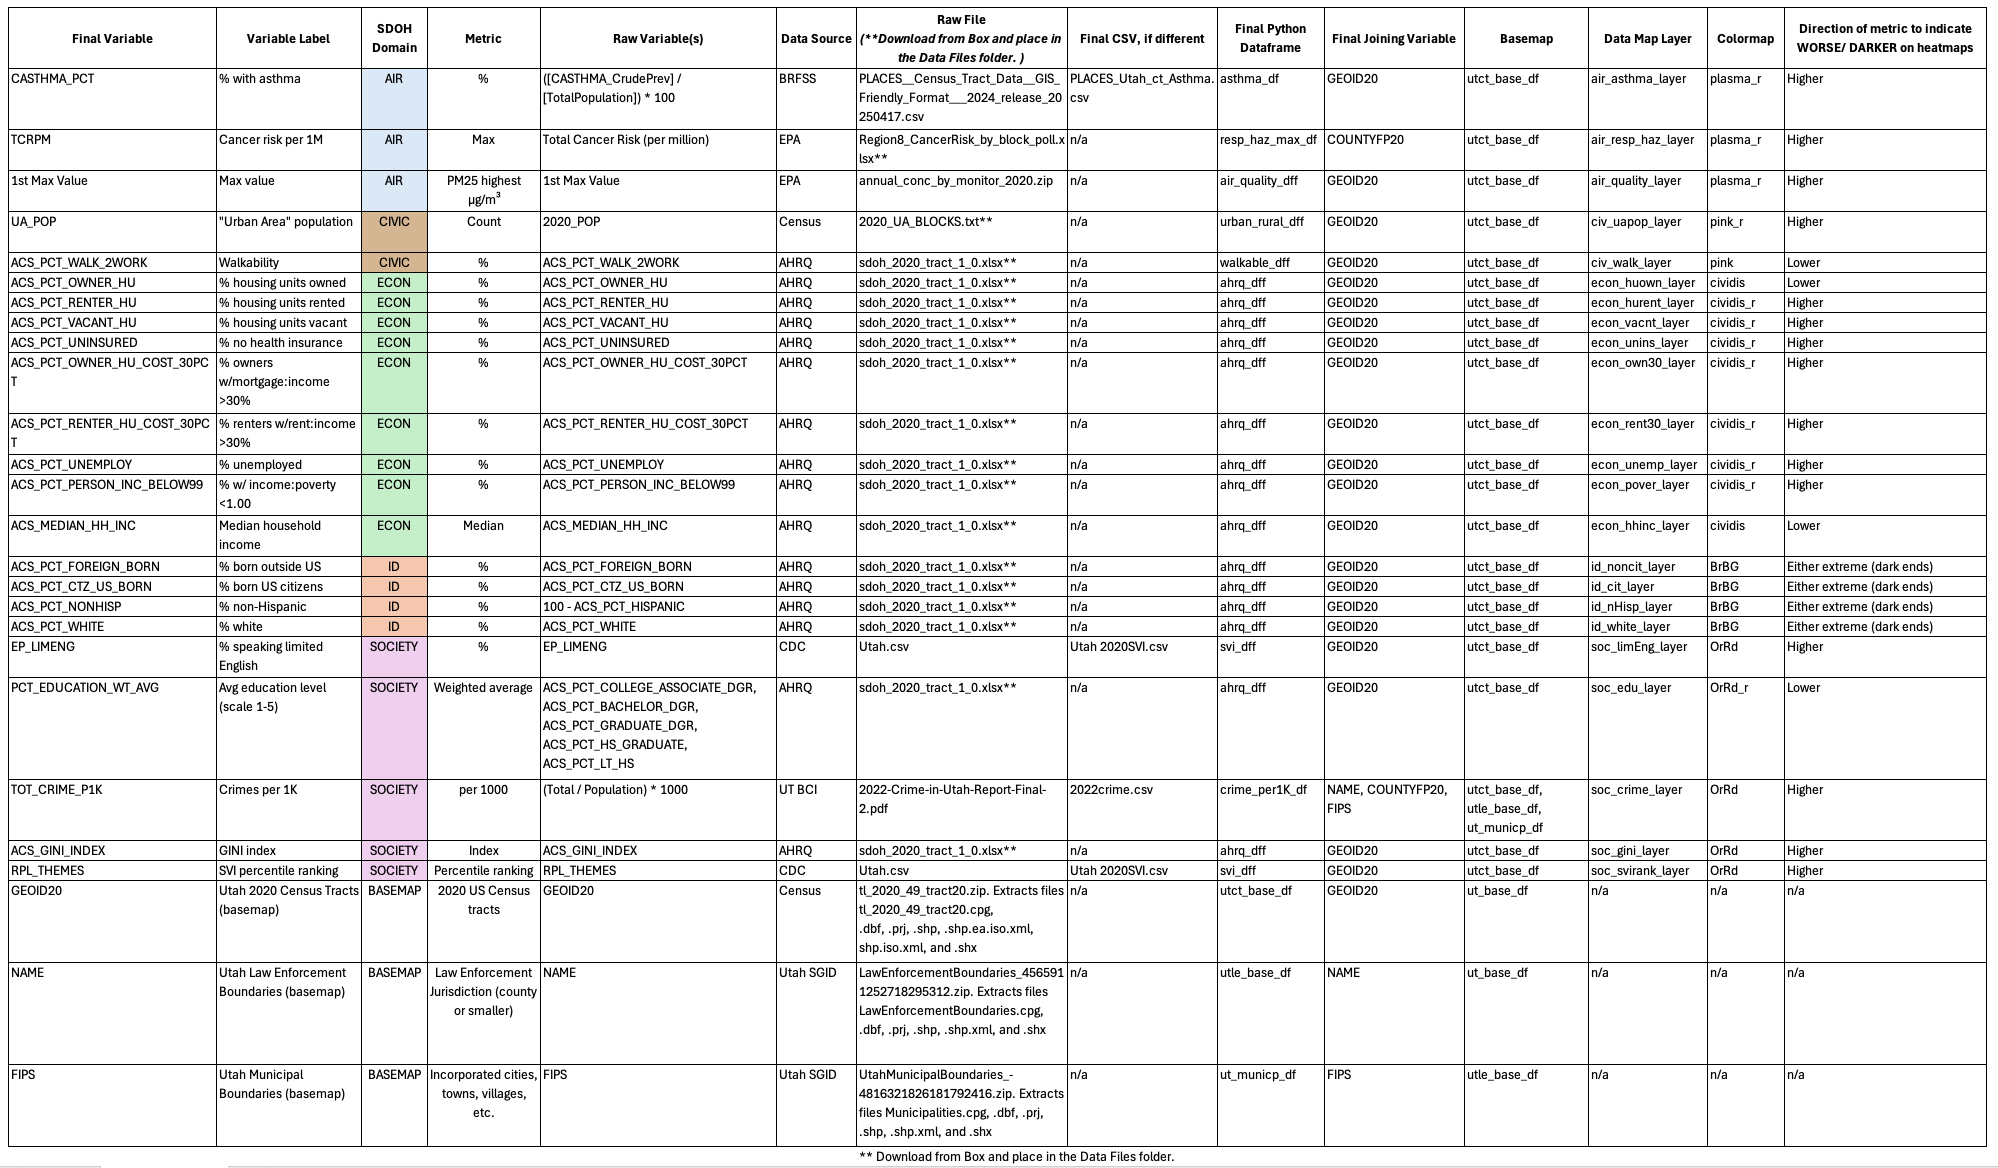

#### Prepare crime layer on a map of law enforcement jurisdictional boundaries (the only data that maps to the law enforcement basemap):

<Axes: >

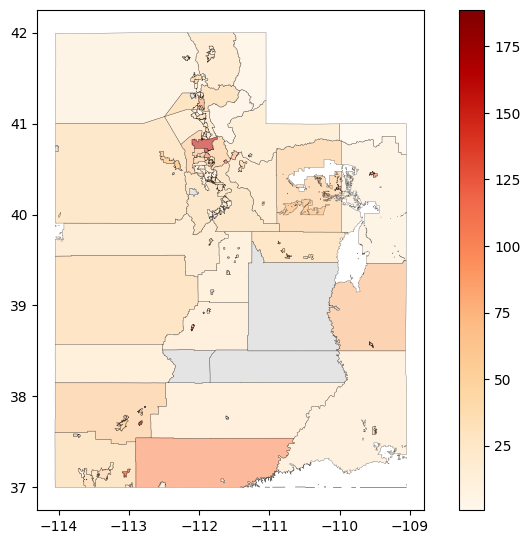

In [25]:
soc_crime_layer = utle_base_df.merge(crime_per1K_df, on='NAME') #THIS is what creates the new GeoDataFrame

soc_crime_layer.plot( #THIS is just for visualizing the GeoDataFrame; it does not change anything. 
    column='TOT_CRIME_P1K',
    cmap='OrRd',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#soc_crime_layer goes into the dictionary.

#### Prepare the respiratory hazard/cancer layer:
##### This was supposed to be at Census block level, rolling up to Census tract, but this year they took a shortcut and rolled all of the Census blocks up to County instead; hence the join on COUNTYFP20.

<Axes: >

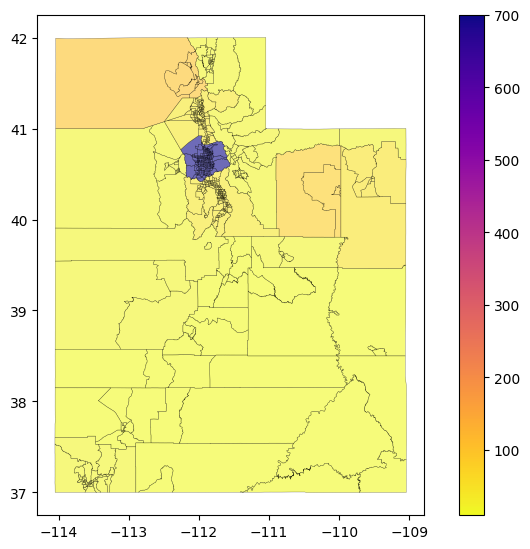

In [26]:
air_resp_haz_layer = utct_base_df.merge(resp_haz_max_df, on='COUNTYFP20')

air_resp_haz_layer.plot(
    column='TCRPM',
    cmap='plasma_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#air_resp_haz_layer into the dictionary.

#### Prepare the other AIR layers:

<Axes: >

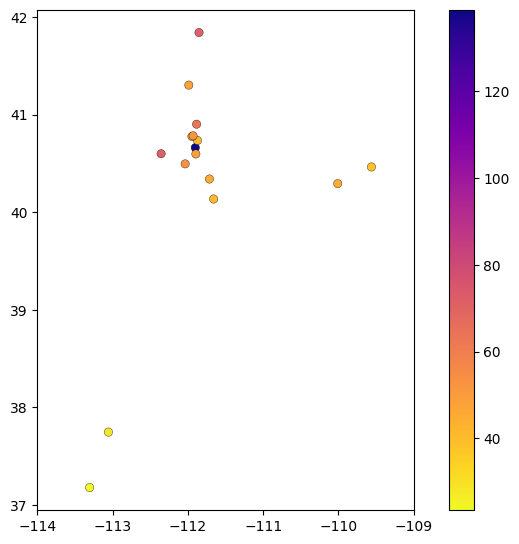

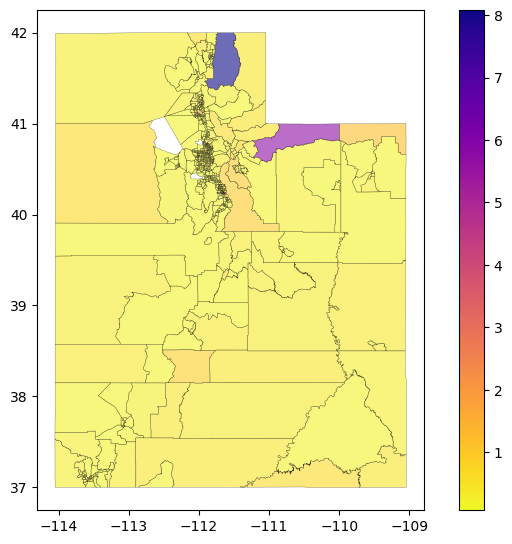

In [27]:
# Air Quality

air_quality_layer = utct_base_df.merge(air_quality_dff, on='GEOID20')
air_quality_layer = air_quality_layer.set_geometry('geometry_y') # Except now we have geometry_x and geometry_y. Use geometry_y
fig, ax = plt.subplots(figsize=(9, 6.5))

# Now plot the '1st Max Value' column
air_quality_layer.plot(
    ax=ax,
    column='1st Max Value',
    cmap='plasma_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=1.0,
    edgecolor="000000",
    linewidth=0.25
)
ax.set_xlim([-114, -109])

#Asthma 

air_asthma_layer = utct_base_df.merge(asthma_df, on='GEOID20')

air_asthma_layer.plot(
    column='CASTHMA_PCT',
    cmap='plasma_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#air_quality_layer into the dictionary.
#air_asthma_layer into the dictionary.

#### Prepare the CIVIC layers:

<Axes: >

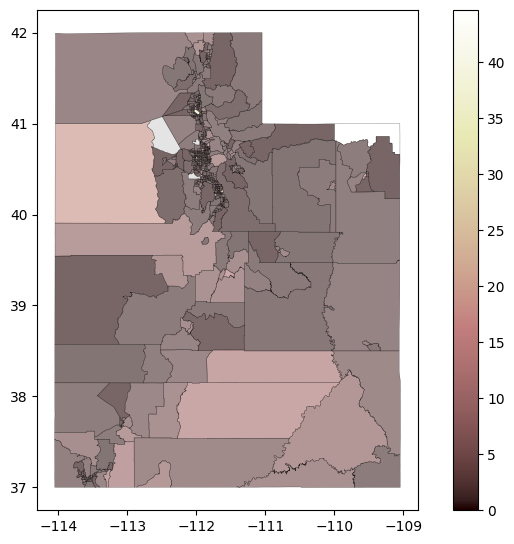

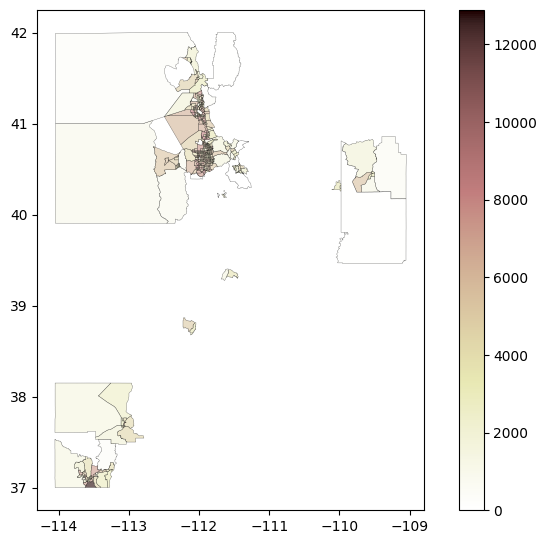

In [28]:
#Walking

civ_walk_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

# Now plot the 'ACS_PCT_WALK_2WORK' column
civ_walk_layer.plot(
    column='ACS_PCT_WALK_2WORK',
    cmap='pink',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Urban Areas

civ_uapop_layer = utct_base_df.merge(urban_rural_dff, on='GEOID20')

civ_uapop_layer.plot(
    column='UA_POP',
    cmap='pink_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#civ_walk_layer into the dictionary.
#civ_uapop_layer into the dictionary.

#### Prepare the Economic layers: 

<Axes: >

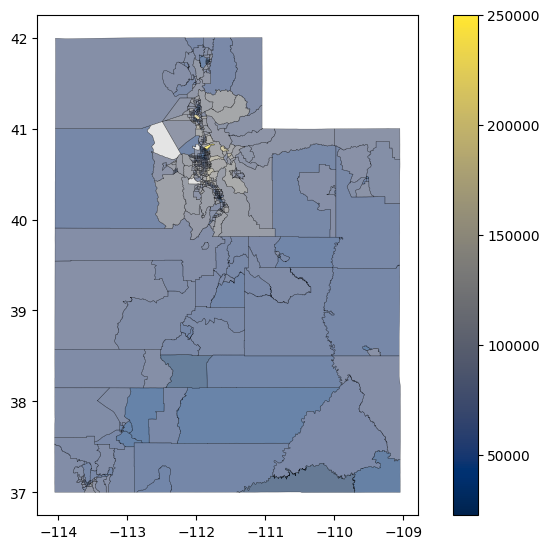

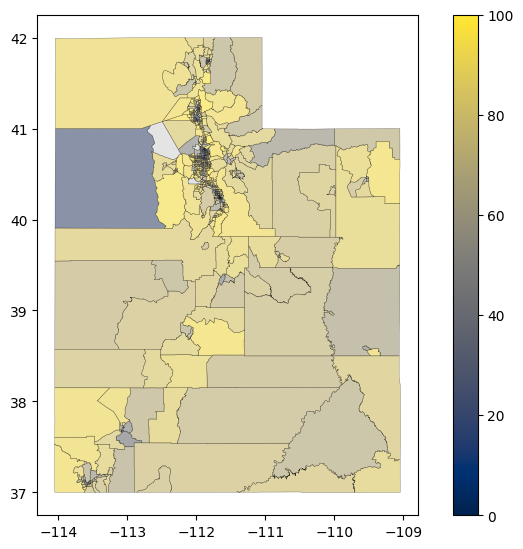

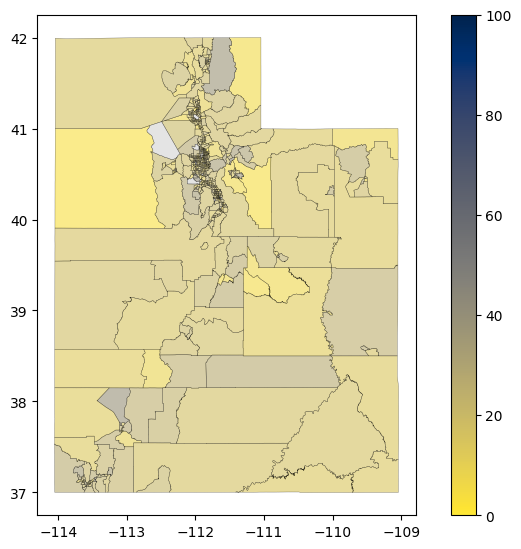

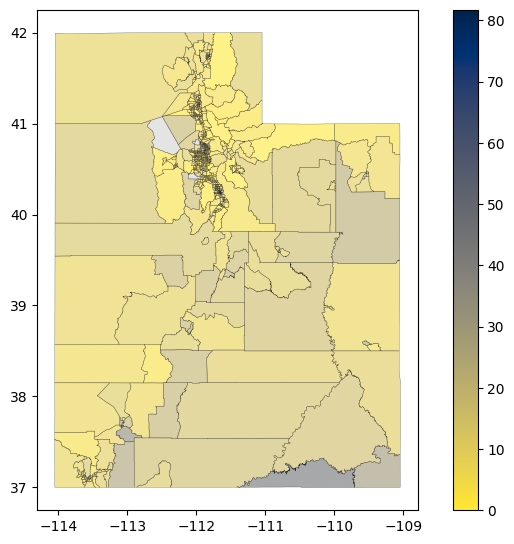

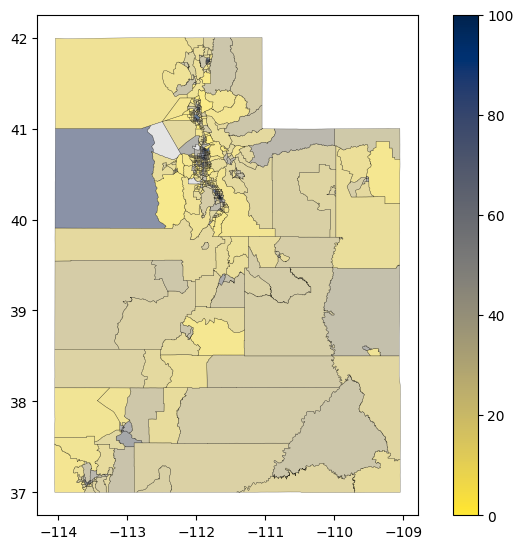

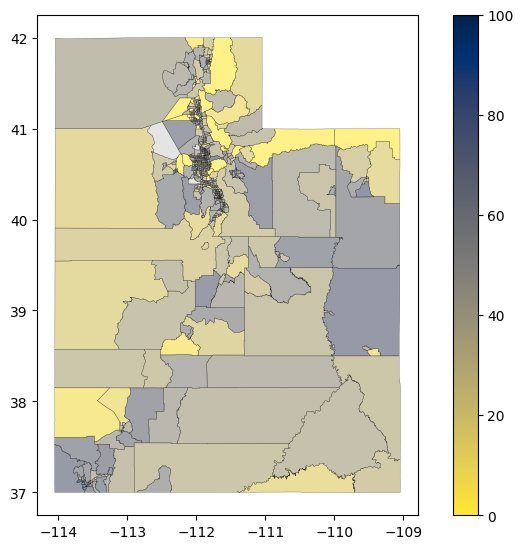

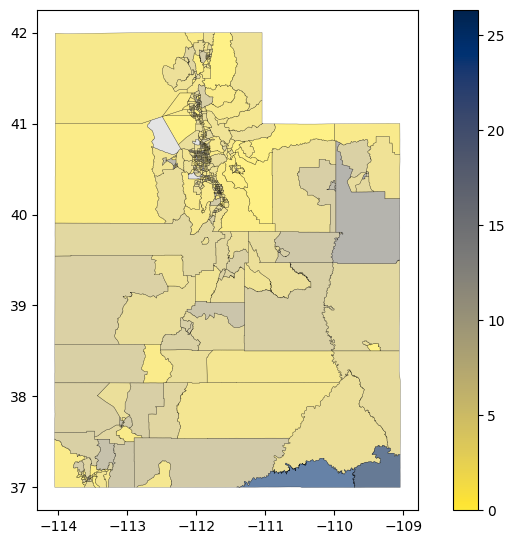

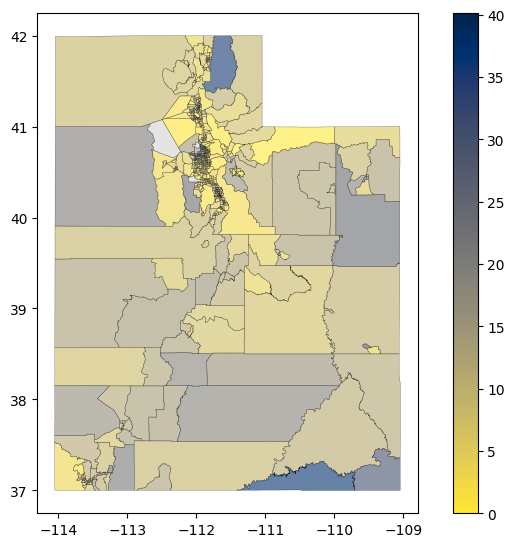

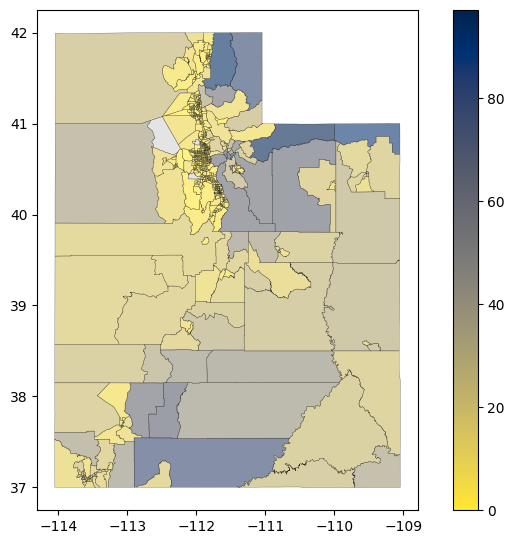

In [29]:
#Houshold income
econ_hhinc_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_hhinc_layer.plot(
    column='ACS_MEDIAN_HH_INC',
    cmap='cividis',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Owner-occupied housing units
econ_huown_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_huown_layer.plot(
    column='ACS_PCT_OWNER_HU',
    cmap='cividis',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Owner-occupied housing units spending >30% on the mortgage
econ_own30_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_own30_layer.plot(
    column='ACS_PCT_OWNER_HU_COST_30PCT',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Percentage of people below the poverty line
econ_pover_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_pover_layer.plot(
    column='ACS_PCT_PERSON_INC_BELOW99',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Renter-occupied housing units
econ_hurent_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_hurent_layer.plot(
    column='ACS_PCT_RENTER_HU',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Renter-occupied housing units spending >30% on rent
econ_rent30_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_rent30_layer.plot(
    column='ACS_PCT_RENTER_HU_COST_30PCT',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Unemployed
econ_unemp_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_unemp_layer.plot(
    column='ACS_PCT_UNEMPLOY',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#Without health insurance
econ_unins_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_unins_layer.plot(
    column='ACS_PCT_UNINSURED',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
    
)

#Unoccupied/Vacant housing units
econ_vacnt_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

econ_vacnt_layer.plot(
    column='ACS_PCT_VACANT_HU',
    cmap='cividis_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#econ_hhinc_layer into the dictionary.
#econ_huown_layer into the dictionary.
#econ_own30_layer into the dictionary.
#econ_pover_layer into the dictionary.
#econ_hurent_layer into the dictionary.
#econ_rent30_layer into the dictionary.
#econ_unemp_layer into the dictionary.
#econ_unins_layer into the dictionary.
#econ_vacnt_layer into the dictionary.

#### Prepare the Identity layers:

<Axes: >

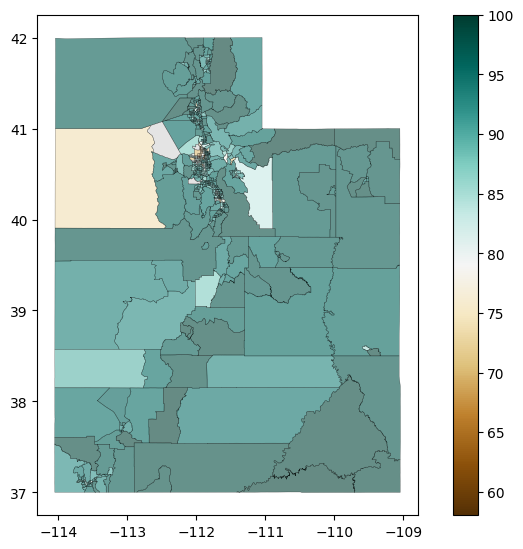

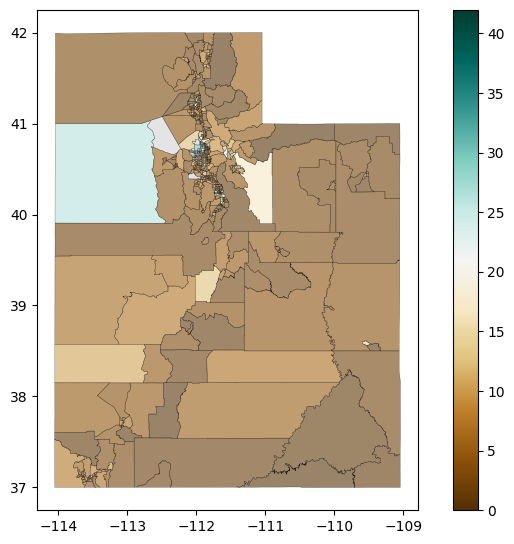

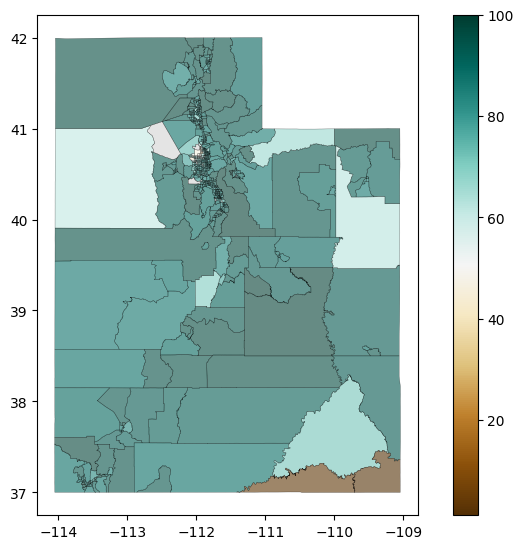

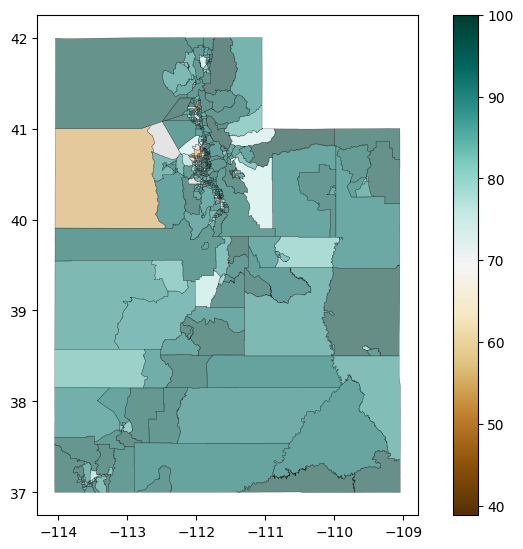

In [30]:
id_cit_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

id_cit_layer.plot(
    column='ACS_PCT_CTZ_US_BORN',
    cmap='BrBG',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

id_noncit_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

id_noncit_layer.plot(
    column='ACS_PCT_FOREIGN_BORN',
    cmap='BrBG',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

id_nHisp_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

id_nHisp_layer.plot(
    column='ACS_PCT_WHITE',
    cmap='BrBG',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

id_white_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

id_white_layer.plot(
    column='ACS_PCT_NONHISP',
    cmap='BrBG',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#id_cit_layer into the dictionary.
#id_noncit_layer into the dictionary.
#id_nHisp_layer into the dictionary.
# #id_white_layer into the dictionary.

#### Prepare the rest of the Society layers:

<Axes: >

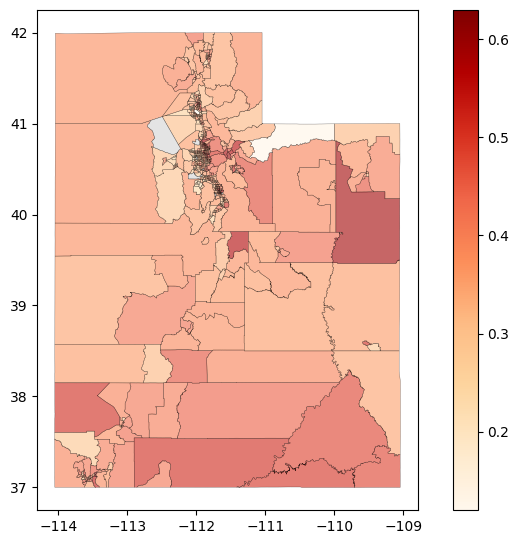

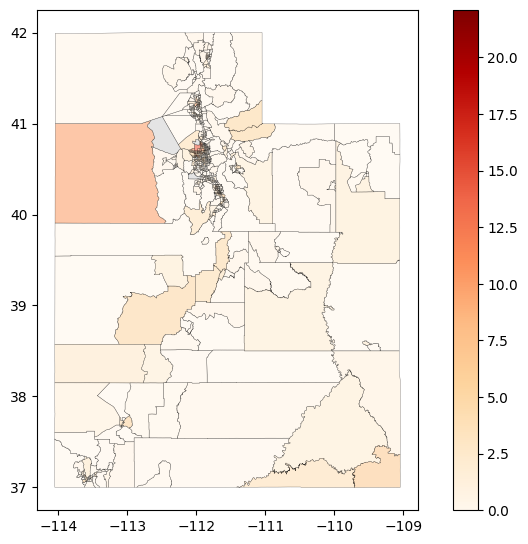

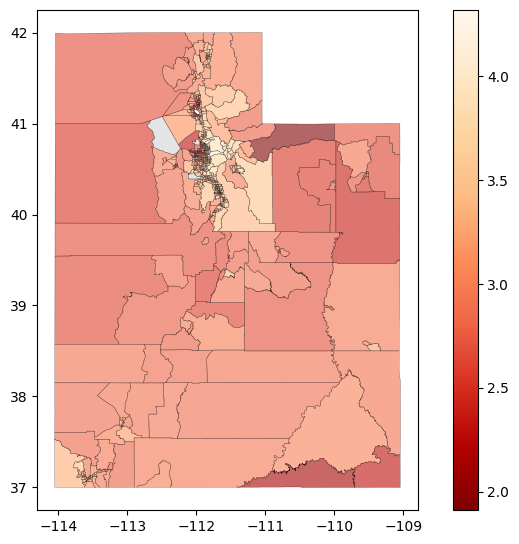

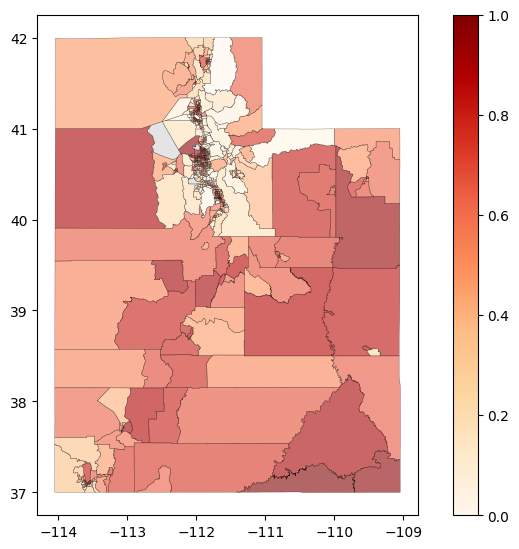

In [31]:
soc_gini_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

soc_gini_layer.plot(
    column='ACS_GINI_INDEX',
    cmap='OrRd',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

soc_limEng_layer = utct_base_df.merge(svi_dff, on='GEOID20')

soc_limEng_layer.plot(
    column='EP_LIMENG',
    cmap='OrRd',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

soc_edu_layer = utct_base_df.merge(ahrq_dff, on='GEOID20')

soc_edu_layer.plot(
    column='PCT_EDUCATION_WT_AVG',
    cmap='OrRd_r',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

soc_svirank_layer = utct_base_df.merge(svi_dff, on='GEOID20')

soc_svirank_layer.plot(
    column='RPL_THEMES',
    cmap='OrRd',
    categorical=False,
    legend=True,
    figsize=(9, 6.5),
    missing_kwds={'color': 'lightgray'},  # Handle NaN values by coloring them light gray)
    alpha=0.6,
    edgecolor="000000",
    linewidth=0.25
)

#soc_gini_layer into the dictionary.
#soc_limEng_layer into the dictionary.
#soc_edu_layer into the dictionary.
#soc_svirank_layer into the dictionary.

# ----------
# TO USE:

## ***Step 1.*** This is your Layers Dictionary. To select a layer for mapping, copy everything to the left of the first colon (:), including the ' ', and paste the text, one per line, in the "Layers to Map" cell, below. Then go to ***Step 2*** (below).

## ***Step 3.*** After you have pasted the layers you want (Step 1) and the latitude and longitude of the address you want to plot (Step 2), come back here to the Layers Dictionary code cell, and run the cells in order, to the end.

In [32]:
#Create dictionary of data layers: 

layers_dict = {
    'Max value': {'layer': air_quality_layer, 'column': '1st Max Value', 'cmap': 'BuPu', 'theme': 'AIR'},
    '% with asthma': {'layer': air_asthma_layer, 'column': 'CASTHMA_PCT', 'cmap': 'BuPu', 'theme': 'AIR'},
    'Cancer risk per 1M': {'layer': air_resp_haz_layer, 'column': 'TCRPM', 'cmap': 'BuPu', 'theme': 'AIR'},
    'Walkability': {'layer': civ_walk_layer, 'column': 'ACS_PCT_WALK_2WORK', 'cmap': 'pink', 'theme': 'CIVIC'},
    '"Urban Area" population': {'layer': civ_uapop_layer, 'column': 'UA_POP', 'cmap': 'pink_r', 'theme': 'CIVIC'},
    'Median household income': {'layer': econ_hhinc_layer, 'column': 'ACS_MEDIAN_HH_INC', 'cmap': 'cividis', 'theme': 'ECON'},
    '% housing units owned': {'layer': econ_huown_layer, 'column': 'ACS_PCT_OWNER_HU', 'cmap': 'cividis', 'theme': 'ECON'},
    '% owners w/mortgage:income >30%': {'layer': econ_own30_layer, 'column': 'ACS_PCT_OWNER_HU_COST_30PCT', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% w/ income:poverty <1.00': {'layer': econ_pover_layer, 'column': 'ACS_PCT_PERSON_INC_BELOW99', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% housing units rented': {'layer': econ_hurent_layer, 'column': 'ACS_PCT_RENTER_HU', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% renters w/rent:income >30%': {'layer': econ_rent30_layer, 'column': 'ACS_PCT_RENTER_HU_COST_30PCT', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% unemployed': {'layer': econ_unemp_layer, 'column': 'ACS_PCT_UNEMPLOY', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% no health insurance': {'layer': econ_unins_layer, 'column': 'ACS_PCT_UNINSURED', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% housing units vacant': {'layer': econ_vacnt_layer, 'column': 'ACS_PCT_VACANT_HU', 'cmap': 'cividis_r', 'theme': 'ECON'},
    '% born US citizens': {'layer': id_cit_layer, 'column': 'ACS_PCT_CTZ_US_BORN', 'cmap': 'BrBG', 'theme': 'ID'},
    '% born outside US': {'layer': id_noncit_layer, 'column': 'ACS_PCT_FOREIGN_BORN', 'cmap': 'BrBG', 'theme': 'ID'},
    '% non-Hispanic': {'layer': id_nHisp_layer, 'column': 'ACS_PCT_NONHISP', 'cmap': 'BrBG', 'theme': 'ID'},
    '% white': {'layer': id_white_layer, 'column': 'ACS_PCT_WHITE', 'cmap': 'BrBG', 'theme': 'ID'},
    'GINI index': {'layer': soc_gini_layer, 'column': 'ACS_GINI_INDEX', 'cmap': 'OrRd', 'theme': 'SOCIETY'},
    '% speaking limited English': {'layer': soc_limEng_layer, 'column': 'EP_LIMENG', 'cmap': 'OrRd', 'theme': 'SOCIETY'},
    'Avg education level (scale 1-5)': {'layer': soc_edu_layer, 'column': 'PCT_EDUCATION_WT_AVG', 'cmap': 'OrRd_r', 'theme': 'SOCIETY'},
    'SVI percentile ranking': {'layer': soc_svirank_layer, 'column': 'RPL_THEMES', 'cmap': 'OrRd', 'theme': 'SOCIETY'},
    'Crimes per 1K': {'layer': soc_crime_layer, 'column': 'TOT_CRIME_P1K', 'cmap': 'OrRd', 'theme': 'SOCIETY'}
}

## ***Step 2.*** This is the latitude/longitude of the address you want to plot. 
### Visit https://www.latlong.net/convert-address-to-lat-long.html and type in the address. Paste the returned latitude and longitude below in the next cell:

In [33]:
#Latitude
lat = 40.765549
  
#Longitude  
lon = -111.850211

In [34]:
# Plot base layers (census tract and law enforcement) and additional data layers dynamically
def ut_base_df(*layers):
    ax = utct_base_df.boundary.plot(
        figsize=(9,6.5),
        linewidth=0.25,
        edgecolor="000000",
        facecolor='none'
        
    )
    utle_base_df.plot( # Plot the law enforcement map onto Census Tract Map, but make it faint
        ax=ax,  # Plot this dataframe on top of the boundary plot
        linewidth=0.15,
        edgecolor="000000",
        facecolor="none"
    )
    
    shown_legends = set('') #Only colormap legends that would display multiple times, given multiple layers in the same domain
    
    
    # Plot all passed layers on top of the base map
    for layer_info in layers:
        layer = layer_info['layer']  # Extract the layer (GeoDataFrame)
        column = layer_info['column']  # Extract the column name for color mapping
        cmap=layer_info['cmap']
        vmin = layer[column].min() # Explicit color normalization, prevents the heatmap outputs from changing weirdly
        vmax = layer[column].max()
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        
        show_legend = cmap not in shown_legends #Only add legend if a cmap hasn't been used yet
        if show_legend:
            shown_legends.add(cmap)

        layer.plot(
            ax=ax,
            column=column,
            cmap=cmap,
            norm=norm,
            categorical=False,
            legend=show_legend,
            legend_kwds={
                'orientation': 'vertical',
                'ticks': []
            },
            linewidth=0.25,
            edgecolor="000000",  # Optional edgecolor to blend layers
            alpha=0.6,
            missing_kwds={'color': 'lightgray'}  # Handle NaN values by coloring them light gray)
        )
    point_geom = [Point(lon, lat)]
    point_gdf = gpd.GeoDataFrame(geometry=point_geom, crs="EPSG:4326")

    if point_gdf.crs != utct_base_df.crs:
        point_gdf = point_gdf.to_crs(utct_base_df.crs)

    point_gdf.plot(
        ax=ax,
        color="#39FF14",
        markersize=50,
        marker='o',
        linewidth=0.15,
        edgecolor="#000000",
        zorder=30  
    )
    
    ax.set_axis_off()  
    return ax  # Return the axis to plot further layers on top

## Layers to Map: Paste your desired layers in the cell below:

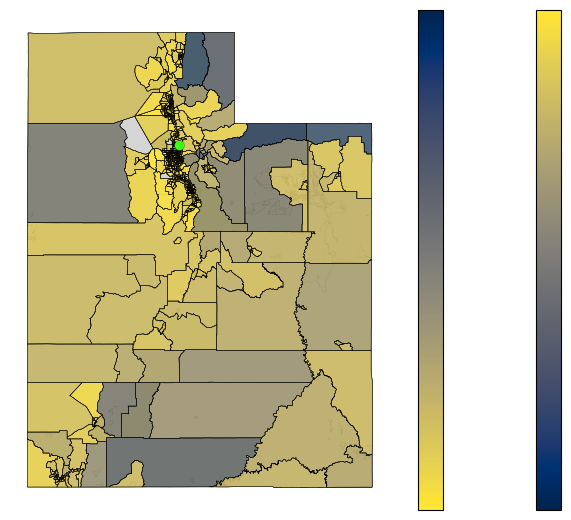

In [35]:

plt.show(ut_base_df(
    layers_dict['% housing units owned'],
    layers_dict['% housing units rented'],
    layers_dict['% housing units vacant']
))

# FIN